In [2]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating project at `~/Documents/eth_courses/notebooks/control/MPC`


In [3]:
# using Pkg
# Pkg.update()
# Pkg.add("BlockArrays")

In [4]:
using LinearAlgebra
using GLMakie
using SparseArrays

import Convex as cvx 
import OSQP
import ECOS

GLMakie.activate!(inline=true)

### Dynamics

In [28]:
# Double integrator in discrtee time
h = 0.1   # time step
A = [1 h; 0 1]
B = [0.5*h*h; h]

n = 2     # number of state
m = 1     # number of controls

Tfinal = 100.0 # final time
N = Int(Tfinal/h)+1    # number of time steps

# Initial conditions
x0 = [1.0; 0]

2-element Vector{Float64}:
 1.0
 0.0

In [29]:
function plot_result(t_vec, xhist, uhist)
    fig = Figure(resolution = (1000, 400))

    ax1 = Axis(fig[1, 1], title="States", xlabel = "time")
    ax2 = Axis(fig[1, 2], title="Control input", xlabel = "time")
    
    
    # t_vec = range(0,h*(N-1), step=h)
    lines!(ax1, t_vec ,xhist[1,:])
    
    lines!(ax1,t_vec,xhist[2,:])
    
    lines!(ax2, t_vec, uhist)
    display(fig)

end

plot_result (generic function with 1 method)

# Unconstrained LQR

## Method 1: Solving KKT System

### Controller

In [30]:
# Cost weights
Q = sparse(1.0*I(2))
R = sparse(0.1*I(1))
Qn = sparse(1.0*I(2))

# Cost
H = blockdiag(R, kron(I(N-2), blockdiag(Q,R)), Qn);

# Constraints
C = kron(I(N-1), [B -I(2)])

for k = 1:N-2
    C[(k*n).+(1:n), (k*(n+m)-n).+(1:n)] .= A
end
d = [-A*x0; zeros(size(C,1)-n)];

In [31]:
#Cost function
function J(xhist,uhist)
    cost = 0.5*xhist[:,end]'*Qn*xhist[:,end]
    for k = 1:(N-1)
        cost = cost + 0.5*xhist[:,k]'*Q*xhist[:,k] + 0.5*(uhist[k]'*R*uhist[k])[1]
    end
    return cost
end

J (generic function with 1 method)

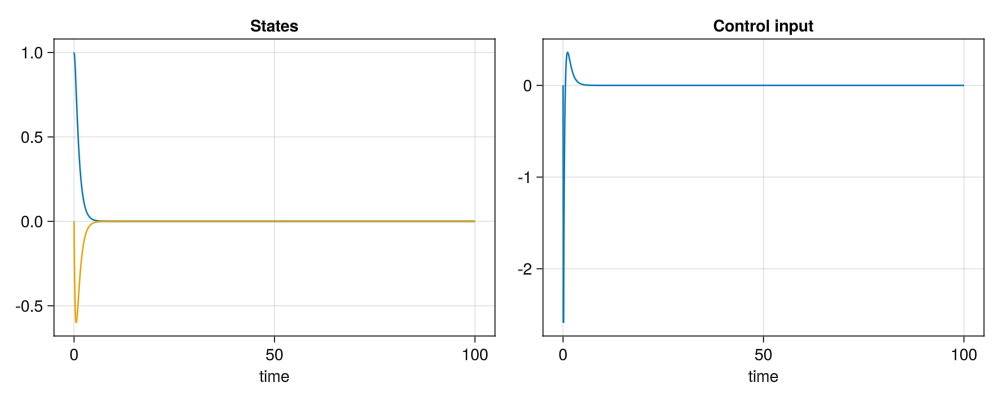

GLMakie.Screen(...)

In [32]:

# Solve the linear system
y = [H C'; C zeros(size(C,1),size(C,1))]\[zeros(size(H,1)); d]

# Get state history
z = y[1:size(H,1)]   # states and controls [u0,x1,u1,...,xN]
Z = reshape(z,n+m,N-1)
xhist = Z[m+1:end,:]
xhist = [x0 xhist]

# Get control history
uhist = Z[1,:];
uhist = [0; uhist]

t_vec = range(0,Tfinal, step=h)

plot_result(t_vec, xhist, uhist)
# print("Cost:", J(xhist,uhist))

## Method 2: using Convex.jl (manually enter matrices)

### Dynamics

In [33]:
# Discrete dynamics
h = 0.1   # time step
A = [1 h;
    0 1]
B = [0.5*h*h;
    h]

n = 2     # number of state
m = 1     # number of controls
Tfinal = 100.0 # final time
N = Int(Tfinal/h)   # number of time steps
t_vec = range(0,Tfinal, step=h)

# Initial conditions
x0 = [1.0; 0]

2-element Vector{Float64}:
 1.0
 0.0

### Controller

In [34]:
# Cost weights
Q = 1.0 * sparse(I(2))
R = 0.1* sparse(I(1))
Qn = 2.0* sparse(I(2))

Q_n = size(Q,1)
A_n = size(A,1)

# Cost (lecture 4 - 15)
Q_block = kron(I(N-1), Q)
Qn_block = Qn
R_block = kron(I(N), R)

H̄ = blockdiag(Q_block, Qn_block, R_block)
H̄ = Matrix(H̄)
H̄ = H̄'*H̄ + I # create PSD matrix 

# Dynamics constrains
G_eq_left_block = blockdiag(kron(I(N), 1.0*sparse(I(2))))

# Add A matrix blocks to lower diagonal of G_eq (lecture 4 - 13)
for k = 1:N-1
    i = (Q_n*k) + 1
    j = Q_n*(k-1) +1
    
    G_eq_left_block[i:i+(A_n-1), j:j+(A_n-1)] .= -A
end

G_eq_right_block = blockdiag(kron(I(N), sparse(-B)));

G_eq = hcat(G_eq_left_block, G_eq_right_block);
  
E_eq = [A; repeat(zeros(n, n), N-1)];


### Solving

In [35]:
z = cvx.Variable(size(A,1)*N + N)
# z = [z, x0]

# NOTE: quadform(x,Q) = x'*Q*x 
cost = 0.5*cvx.quadform(z,H̄) 

prob = cvx.minimize(cost)

# dynamics constraint
prob.constraints += (G_eq*z == E_eq*x0)

cvx.solve!(prob, ECOS.Optimizer; silent_solver = true)

z_val= z.value::Matrix; # This will always be a matrix
z_val= vec(z.value); # convert to vector easily 

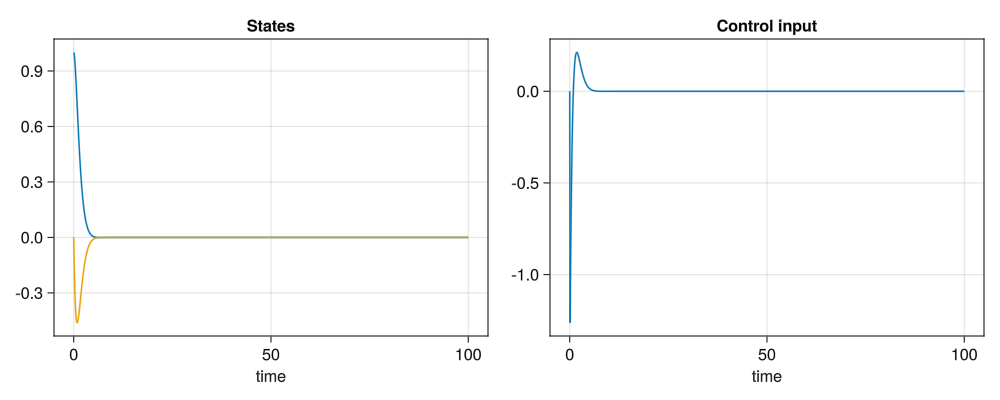

GLMakie.Screen(...)

In [36]:
xhist = z_val[1:2*N]
xhist = reshape(xhist, 2,N)

# Get control history
uhist = z_val[2*N+1:end];

# append initial state and initial control input
xhist = [x0 xhist]
uhist = [0; uhist]

plot_result(t_vec, xhist, uhist)
# print("Cost:", J(xhist,uhist))

## Constrained LQR 

In [41]:
# state constrain
b_x = 5;

# control constrain (Lecture 4- 14)
b_u = 0.1;

A_x = 1.0*sparse(I(n))
A_u = 1.0*sparse(I(m))

A_block = kron(I(N-1), A_x)
A_u_block = kron(I(N), A_u)

G_ineq = blockdiag(sparse(zeros(n,n)), A_block, A_u_block);

w_in = [repeat(ones(n,1)*b_x, N) ; repeat(ones(m,1)*b_u, N)];

E_in = [-A_x; repeat(zeros(n, n), N-1); repeat(zeros(1, 2), N)];

In [42]:
# state constrain
b_x = 5;

# control constrain 
b_u = 0.1;

A_x = 1.0*sparse(I(n))
A_u = 1.0*sparse(I(m))

G_in = blockdiag(sparse(zeros(n,n)), kron(I(N-1), A_x), kron(I(N), A_u));

w_in = [repeat(ones(n,1)*b_x, N) ; repeat(ones(m,1)*b_u, N)];
E_in = [-A_x; repeat(zeros(n, n), N-1); repeat(zeros(1, 2), N)];

## Solving using convex.jl

In [43]:
z = cvx.Variable(size(A,1)*N + N)

# NOTE: quadform(x,Q) = x'*Q*x 
cost = 0.5*cvx.quadform(z,H̄) 

prob = cvx.minimize(cost)

# dynamics constraint
prob.constraints += (G_eq*z == E_eq*x0)

# state, control constrains
prob.constraints += (G_ineq*z <= w_in + E_in*x0)

cvx.solve!(prob, ECOS.Optimizer; silent_solver = true)

z_val= z.value::Matrix; # This will always be a matrix
z_val= vec(z.value); # convert to vector easily 

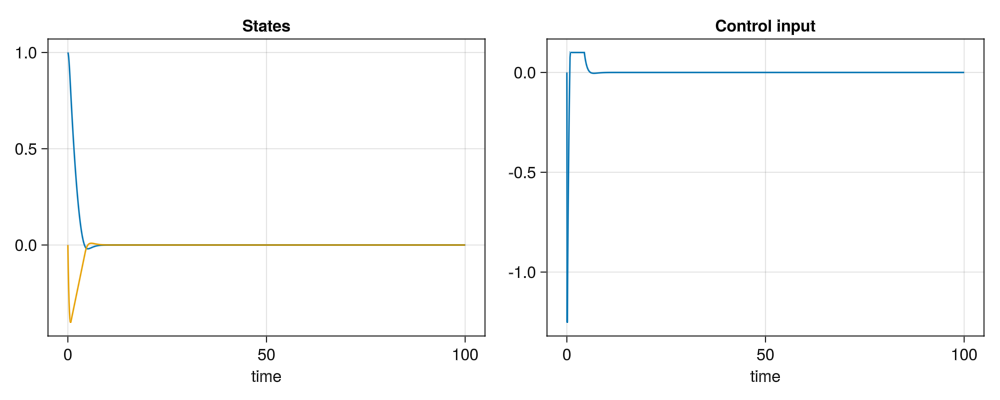

GLMakie.Screen(...)

In [44]:
xhist = z_val[1:2*N]
xhist = reshape(xhist, 2,N)
# xhist = [x0 xhist]

# Get control history
uhist = z_val[2*N+1:end];

# append initial state and initial control input
xhist = [x0 xhist]
uhist = [0; uhist]

plot_result(t_vec, xhist, uhist)

## Method 3: using Convex.jl (disciplined convex programming)